<a href="https://colab.research.google.com/github/Gabriele90/Biohacker90/blob/main/Virtual_Screening_Workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Prepare the Dataset for Building a Predictive Model**

As a first step we will build a graph convolution model predict ERK2 activity. We will train the model to distinguish a set of ERK2 active compounds from a set of decoy compounds. The active and decoy compounds are derived from the DUD-E database. In order to generate the best model, we would like to decoys with property distributions similar to those of our active compounds. Let's say this was not the case and the inactive compounds had lower molecular weight than the active compounds. In this case our classifer may be trained to simply separate low molecular compounds from high molecular weight compounds. This classifer will have very limited utility in preactice.

As a first step, we will examine a few calculated properties of our active and decoy molecules. In order to build a reliable model, we need to ensure that the properties of the active molecules are similar to those of the decoy molecules.

First lets import the libraries we will need.

In [1]:
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
! conda install -c rdkit rdkit -y
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

--2020-11-14 13:11:15--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8303, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85055499 (81M) [application/x-sh]
Saving to: ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh’

Miniconda3-py37_4.8 100%[===================>]  81.12M   156MB/s    in 0.5s    

2020-11-14 13:11:15 (156 MB/s) - ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh’ saved [85055499/85055499]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: - done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - asn1crypto==1.3.0=py37_0
    - ca-certificates==2020.1.1=0
    - certifi==2019.11.28=py37_0
    - cffi==1.14.0=py37h2e261b9_0
    - chardet==3.0.4=py37_1003
    - conda-package-handling==1.6.0=py37h7b64

In [2]:
import pandas as pd

In [3]:
from rdkit import Chem

In [4]:
import numpy as np
from rdkit.Chem import Descriptors

In [5]:
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
import pandas as pd
from rdkit.Chem import PandasTools
from rdkit.Chem import rdmolops
import seaborn as sns

Now we can read a SMILES file into a Pandas dataframe and add an RDKit molecule to the dataframe.

In [6]:
active_df = pd.read_csv("actives_final.ism.txt",header=None,sep=" ")
active_rows,active_cols = active_df.shape
active_df.columns = ["SMILES","ID","ChEMBL_ID"]
active_df["label"] = ["Active"]*active_rows
PandasTools.AddMoleculeColumnToFrame(active_df,"SMILES","Mol")

Let's define a function to add caculated properties to a dataframe

In [7]:
def add_property_columns_to_df(df_in):
    df_in["mw"] = [Descriptors.MolWt(mol) for mol in df_in.Mol]
    df_in["logP"] = [Descriptors.MolLogP(mol) for mol in df_in.Mol]
    df_in["charge"] = [rdmolops.GetFormalCharge(mol) for mol in df_in.Mol]

With this function in hand, we can calculate the molecular weight, LogP and formal charge of the molecules. Once we have these properties we can compare the distributions for the active and decoy sets.

In [8]:
add_property_columns_to_df(active_df)

Let's look at the frist few rows of our dataframe to ensure that it makes sense.

,SMILES,ID,ChEMBL_ID,label,Mol,mw,logP,charge
0,Cn1ccnc1Sc2ccc(cc2Cl)Nc3c4cc(c(cc4ncc3C#N)OCCC...,168691,CHEMBL318804,Active,,565.099,5.49788,0
1,C[C@@]12[C@@H]([C@@H](CC(O1)n3c4ccccc4c5c3c6n2...,86358,CHEMBL162,Active,,466.541,4.35400,0
2,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3...,575087,CHEMBL576683,Active,,527.915,4.96202,0
3,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3...,575065,CHEMBL571484,Active,,491.935,4.36922,0
4,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3...,575047,CHEMBL568937,Active,,487.991,5.12922,0

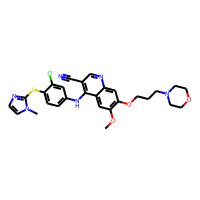
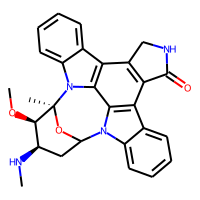
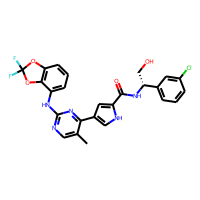
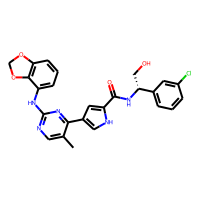
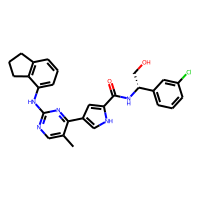

In [9]:
active_df.head()

Now let's do the same thing with the decoy molecules

In [10]:
decoy_df = pd.read_csv("decoys_final.ism.txt",header=None,sep=" ")
decoy_df.columns = ["SMILES","ID"]
decoy_rows, decoy_cols = decoy_df.shape
decoy_df["label"] = ["Decoy"]*decoy_rows
PandasTools.AddMoleculeColumnToFrame(decoy_df,"SMILES","Mol")
add_property_columns_to_df(decoy_df)

In [11]:
tmp_df = active_df.append(decoy_df)

With properties calculated for both the active and the decoy sets, we can compare the properties of the two compound sets. To do the comparison, we will use violin plots. A violin plot can be thought of as analogous to a boxplot. The violin plot provides a mirrored, horizontal view of a frequency distribution. Ideally, we would like to see similar distributions for the active and decoy sets.

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


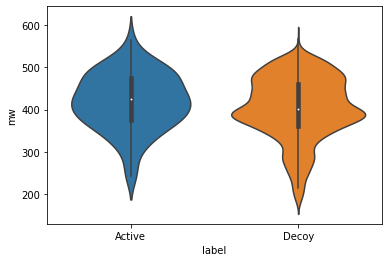

In [12]:
sns.violinplot(tmp_df["label"],tmp_df["mw"])

An examination of the distributions in the figures above show that the molecular weight distributions for the two sets are roughly equivalent. The decoy set has more low molecular weight molecules, but the center of the distribution, show as a box in the middle of each violin plot is in a similar location in both plots.

We can use violin plots to perform a similar comparison of the LogP distributions. Again, we can see that the distributions are similar with a few more decoys at the lower end of the distribution.

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


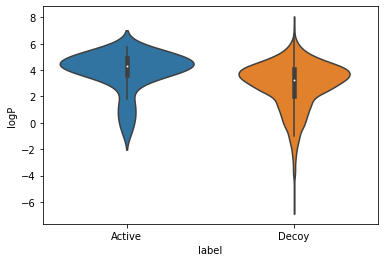

In [13]:
sns.violinplot(tmp_df["label"],tmp_df["logP"])

Finally, we will do the same comparison with the formal charges of the molecules.

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


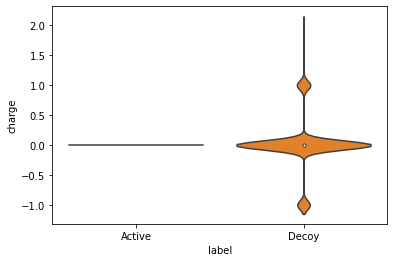

In [14]:
sns.violinplot(tmp_df["label"],tmp_df["charge"])

In this case, we see a signficant difference. All of the active molecules are neutral, while some of the decoys are charged. Let see what fraction of the decoy molecules are charged. We can do this by creating a new dataframe with just the charged molecules.

In [15]:
charged = decoy_df[decoy_df["charge"] != 0]

A pandas dataframe has a property, shape, that returns the number of rows and columns in the dataframe. As such, element[0] in the shape property will be the number of rows. Let's divide the number of rows in our dataframe of charged molecules by the total number of rows in the decoy dataframe.

In [16]:
charged.shape[0]/decoy_df.shape[0]

0.16175824175824177


The fact that 16% of the decoy compounds are charged, while none of the active compounds are is a concern. An examination of both sets indicate that charge states were assigned to the decoys, but not to the active molecules. In order to be consistent, we will use some code from the RDKit Cookbook to neutralize the molecules (https://rdkit.readthedocs.io/en/latest/Cookbook.html#neutralizing-charged-molecules). First, we will import an RDKit function to neutralize charges.

In [17]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw

In [18]:
def _InitialiseNeutralisationReactions():
    patts= (
        # Imidazoles
        ('[n+;H]','n'),
        # Amines
        ('[N+;!H0]','N'),
        # Carboxylic acids and alcohols
        ('[$([O-]);!$([O-][#7])]','O'),
        # Thiols
        ('[S-;X1]','S'),
        # Sulfonamides
        ('[$([N-;X2]S(=O)=O)]','N'),
        # Enamines
        ('[$([N-;X2][C,N]=C)]','N'),
        # Tetrazoles
        ('[n-]','[nH]'),
        # Sulfoxides
        ('[$([S-]=O)]','S'),
        # Amides
        ('[$([N-]C=O)]','N'),
        )
    return [(Chem.MolFromSmarts(x),Chem.MolFromSmiles(y,False)) for x,y in patts]

_reactions=None
def NeutraliseCharges(smiles, reactions=None):
    global _reactions
    if reactions is None:
        if _reactions is None:
            _reactions=_InitialiseNeutralisationReactions()
        reactions=_reactions
    mol = Chem.MolFromSmiles(smiles)
    replaced = False
    for i,(reactant, product) in enumerate(reactions):
        while mol.HasSubstructMatch(reactant):
            replaced = True
            rms = AllChem.ReplaceSubstructs(mol, reactant, product)
            mol = rms[0]
    if replaced:
        return (Chem.MolToSmiles(mol,True), True)
    else:
        return (smiles, False)

Now we will create a new dataframe with the SMILES, ID, and label for the decoys.

In [19]:
revised_decoy_df = decoy_df[["SMILES","ID","label"]].copy()


With this new dataframe in hand, we can replace the SMILES with the SMILES for the neutral form of the molecule. The NeutraliseCharges function returns two values. The first is the SMILES for the neutral form of the molecule and the second is a boolean variable indicating whether the molecule was changed. In the code below, we only need the SMILES, so we will use the first element of the tuple returned by NeutraliseCharges.

In [20]:
revised_decoy_df["SMILES"] = [NeutraliseCharges(x)[0] for x in revised_decoy_df["SMILES"]]

Once we've replaced the SMILES, we can add a molecule column to our new dataframe and calculated properties again.

In [21]:
PandasTools.AddMoleculeColumnToFrame(revised_decoy_df,"SMILES","Mol")
add_property_columns_to_df(revised_decoy_df)

We can now append the dataframe with the active molecules to the one with the revised, neutral decoys and calculate another box plot.

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


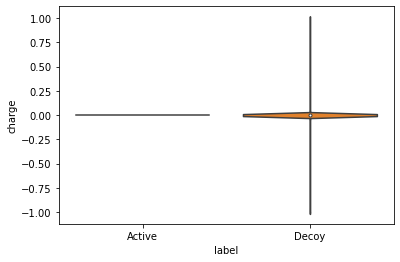

In [22]:
new_tmp_df = active_df.append(revised_decoy_df)
sns.violinplot(new_tmp_df["label"],new_tmp_df["charge"])

An examination of the plot about show that there are very few charged molecules in the decoy set. We can use the same technique we used above to create a dataframe with only the charged molecules. We can then use this dataframe to determine the number of charged molecules remaining in the set.

In [23]:
charged = revised_decoy_df[revised_decoy_df["charge"] != 0]
charged.shape[0]/revised_decoy_df.shape[0]

0.0026373626373626374

We have now reduced the fraction of charged compounds from 16% to 0.3%. We can now be confident that our active and decoy sets are reasonbly well balanced.

In order to use these datasets with DeepChem we need to write the molecules out as a csv file consisting of SMILES, Name, and an integer value indicating whether the compounds are active (labeled as 1) or inactive (labeled as 0).

In [24]:
active_df["is_active"] = [1] * active_df.shape[0]
revised_decoy_df["is_active"] = [0] * revised_decoy_df.shape[0]
combined_df = active_df.append(revised_decoy_df)[["SMILES","ID","is_active"]]
combined_df.head()

,SMILES,ID,is_active
0,Cn1ccnc1Sc2ccc(cc2Cl)Nc3c4cc(c(cc4ncc3C#N)OCCC...,168691,1
1,C[C@@]12[C@@H]([C@@H](CC(O1)n3c4ccccc4c5c3c6n2...,86358,1
2,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3...,575087,1
3,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3...,575065,1
4,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3...,575047,1


Our final step in this section is to save our new combined_df as a csv file. The index=False option causes Pandas to not include the row number in the first column.

In [25]:
combined_df.to_csv("dude_erk1_mk01.csv")

**Training a Graph Convolution Model**

Now that we have the data appropriately formatted, we can use this data to train a Graph Convolution model. First we need to import the necessary libraries.

In [26]:
!curl -Lo conda_installer.py https://raw.githubusercontent.com/deepchem/deepchem/master/scripts/colab_install.py
import conda_installer
conda_installer.install()
!/root/miniconda/bin/conda info -e

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3490  100  3490    0     0  17537      0 --:--:-- --:--:-- --:--:-- 17626


add /root/miniconda/lib/python3.6/site-packages to PYTHONPATH
python version: 3.6.9
fetching installer from https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
done
installing miniconda to /root/miniconda
done
installing rdkit, openmm, pdbfixer
added conda-forge to channels
added omnia to channels
done
conda packages installation finished!


# conda environments:
#
base                  *  /root/miniconda
                         /usr/local



In [27]:
!pip install --pre deepchem

     |████████████████████████████████| 402 kB 4.4 MB/s 
     |████████████████████████████████| 301 kB 18.2 MB/s 
     |████████████████████████████████| 6.8 MB 18.5 MB/s 
     |████████████████████████████████| 25.9 MB 1.0 kB/s 
  Created wheel for deepchem: filename=deepchem-2.4.0rc1.dev20201114131456-py3-none-any.whl size=513172 sha256=2c4603d35676d20cc3b2dcf8bd5791bf704fe62066bfc07270441fddecee7d2f
  Stored in directory: /root/.cache/pip/wheels/ef/5e/93/381e0559fdd35b7440483fbfbfd43c079ad93564525692761c
Successfully built deepchem


In [46]:
import deepchem as dc
from deepchem.models import GraphConvModel
import numpy as np
import sys
import pandas as pd
import seaborn as sns
from rdkit.Chem import PandasTools

Now let's define a function to create a GraphConvModel. In this case we will be creating a classification model. Since we will be apply the model later on a different dataset, it's a good idea to create a directory in which to store the model.

In [49]:
def generate_graph_conv_model():
    batch_size = 128
    model = GraphConvModel(1, batch_size=batch_size, mode='classification',model_dir="./model_dir")
    return model

Now we will read in the dataset that we just created.

In [51]:
dataset_file = "dude_erk1_mk01.csv"
tasks = ["is_active"]
featurizer = dc.feat.ConvMolFeaturizer()
loader = dc.data.CSVLoader(tasks=tasks, feature_field="SMILES", featurizer=featurizer)
dataset = loader.create_dataset(dataset_file, shard_size=8192)
dataset

<DiskDataset X.shape: (4629,), y.shape: (4629, 1), w.shape: (4629, 1), task_names: ['is_active']>

Now that we have the dataset loaded, let's build a model. We will create training and test sets to evaluate the model's performance. In this case we will use the RandomSplitter(). DeepChem offers a number of other splitters such as the ScaffoldSplitter, which will divide the dataset by chemical scaffold or the ButinaSplitter which will first cluster the data then split the dataset so that different clusters will end up in the training and test sets.

In [54]:
splitter = dc.splits.RandomSplitter()

With the dataset split, we can train a model on the training set and test that model on the validation set. At this point we can define some metrics and evaluate the performance of our model. In this case our dataset is unbalanced, we have a small number of active compounds and a large number of inactive compounds. Given this difference, we need to use a metric that reflects the performance on unbalanced datasets. One metric that is apporpriate for datasets like this is the Matthews correlation coefficient (MCC). Put more info about MCC here.

In [1]:
metrics = [dc.metrics.Metric(dc.metrics.matthews_corrcoef, np.mean, mode="classification")]

NameError: ignored

In order to evaluate the performance of our model, we will perform 10 folds of cross
validation, where we train a model on the training set and validate on the validation
set:

In [161]:
training_score_list = []
validation_score_list = []
transformers = []
cv_folds = 5
for i in range(0,cv_folds):
    model = generate_graph_conv_model()
    train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(dataset)
    model.fit(train_dataset)

print(training_score_list)
print(validation_score_list)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


KeyboardInterrupt: ignored

In [78]:
pred = [x.flatten() for x in model.predict(valid_dataset)]

The results of predict on a GraphConv model are returned as a list of lists. Is this the intent? It doesn't seem consistent across models. RandomForest returns a list. For convenience, we will put our predicted results into a Pandas dataframe.

In [79]:
pred_df = pd.DataFrame(pred,columns=["neg","pos"])

We can easily add the activity class (1 = active, 0 = inactive) and the SMILES string for our predicted molecules to the dataframe. Is the moleculed id retained as part of the DeepChem dataset? I can't find it

In [81]:
pred_df["active"] = [int(x) for x in valid_dataset.y]
pred_df["SMILES"] = valid_dataset.ids

In [82]:
pred_df.head()

,neg,pos,active,SMILES
0,0.999121,0.000879,0,CCCOC(=O)C1=C(Nc2nc(nn2[C@@H]1c3ccc(c(c3)OC)OC...
1,0.999506,0.000494,0,C[C@@H]1CCc2c(sc3c2c(nc(n3)CSc4nnc(n4N)c5ccc(c...
2,0.998472,0.001528,0,c1cc(ccc1NC(=O)NCSSCNC(=O)Nc2ccc(cc2)Cl)Cl
3,0.999976,0.000024,0,Cc1ccc(c(c1)C)NC(=O)Nc2ccc(cc2)NC(=O)N3CCC[C@@...
4,0.999674,0.000326,0,CCOC(=O)NNC(=O)c1ccc(cc1)S(=O)(=O)Nc2ccc(c(c2)C)C


In [83]:
pred_df.sort_values("pos",ascending=False).head(25)

,neg,pos,active,SMILES
280,0.197075,0.802925,1,CCN(C)C(=O)c1cc(c[nH]1)c2c(cn[nH]2)c3cccc(c3)Cl
341,0.557322,0.442678,1,c1cc(cc(c1)Cl)c2cn[nH]c2c3cc([nH]c3)C(=O)NCc4c...
346,0.573720,0.426281,1,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3ccccc3)...
55,0.678796,0.321204,1,c1cnc(nc1c2cc3c([nH]2)[C@H](CNC3=O)CCF)N
277,0.679756,0.320244,0,CN[C@@H]1c2c(ccc(c2NC1=O)F)Cl
167,0.765514,0.234486,1,Cc1cccc(c1C)Nc2ncc(c(n2)c3cc([nH]c3)C(=O)N[C@H...
19,0.789070,0.210930,1,CCc1ccccc1Nc2ncc(c(n2)c3cc([nH]c3)C(=O)N[C@H](...
312,0.796359,0.203641,1,c1ccc2c(c1)CCN(C2)C(=O)c3cc(c[nH]3)c4c(cn[nH]4...
383,0.847507,0.152493,1,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3...
417,0.910684,0.089316,0,c1cc(c(cc1F)Br)Nc2cc3c(cc2N)OCCO3


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


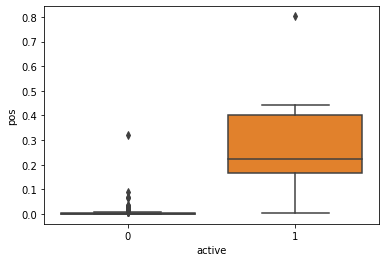

In [84]:
sns.boxplot(pred_df.active,pred_df.pos)

The performance of our model is very good, we can see a clear separation between the active and inactive compounds. It appears that only one of our active compounds receieved a low positive score. Let's look more closely.

In [85]:
false_negative_df = pred_df.query("active == 1 & pos < 0.5").copy()

,neg,pos,active,SMILES,Mol
6,0.997621,0.002379,1,c1c(c2c(ncnc2n1[C@H]3[C@@H]([C@@H]([C@H](O3)CO...,
19,0.789070,0.210930,1,CCc1ccccc1Nc2ncc(c(n2)c3cc([nH]c3)C(=O)N[C@H](...,
55,0.678796,0.321204,1,c1cnc(nc1c2cc3c([nH]2)[C@H](CNC3=O)CCF)N,
167,0.765514,0.234486,1,Cc1cccc(c1C)Nc2ncc(c(n2)c3cc([nH]c3)C(=O)N[C@H...,
312,0.796359,0.203641,1,c1ccc2c(c1)CCN(C2)C(=O)c3cc(c[nH]3)c4c(cn[nH]4...,
341,0.557322,0.442678,1,c1cc(cc(c1)Cl)c2cn[nH]c2c3cc([nH]c3)C(=O)NCc4c...,
346,0.573720,0.426281,1,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3ccccc3)...,
351,0.955184,0.044816,1,CCCCNC(=O)N1Cc2c(n[nH]c2NC(=O)Cc3ccc(cc3)N4CCC...,
383,0.847507,0.152493,1,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3...,

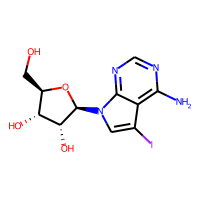
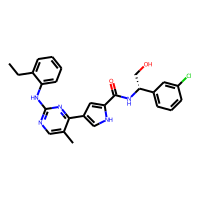
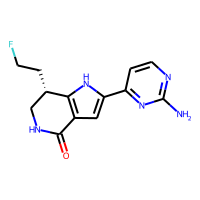
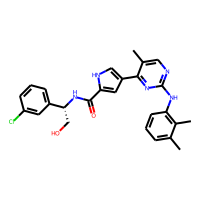
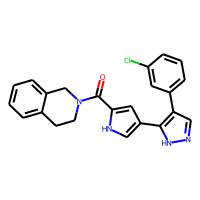
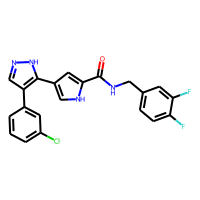
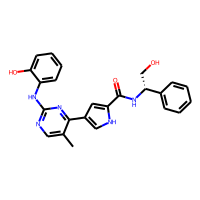
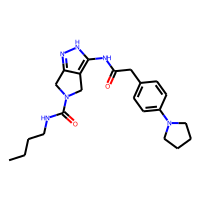
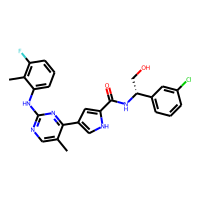

In [86]:
PandasTools.AddMoleculeColumnToFrame(false_negative_df,"SMILES","Mol")
false_negative_df

In [87]:
false_positive_df = pred_df.query("active == 0 & pos > 0.5").copy()
PandasTools.AddMoleculeColumnToFrame(false_positive_df,"SMILES","Mol")

In [88]:
false_positive_df

,neg,pos,active,SMILES,Mol


Now that we've evaluated our model's performance we can retrain the model on the entire dataset and save it.

In [89]:
model.fit(dataset)

0.0005924772471189499

**Filtering chemical libraries**

Now that we've created a predictive model we can apply this model to a new set of molecules. In many cases, we will build a predictive model based on literature data, then apply that model to a set of molecules that we want to screen. The molecules we want to screen may come from an internal database or from a commercially available screening collection. As an example, we will use the predictive model we created to screen a small sample of 100,000 compounds from the ZINC database.

One potential source of difficulty when carrying out a virtual screen is the presence of molecules which have the potential to interfere with biological assays. Over the last 25 years, many groups have developed sets of computational filters to identify potentially reactive or problematic molecules. Several of these rule sets, which are encoded as SMARTS strings have been collected by the group that curates the ChEMBL database. These rule sets have been made avaiable through a Python script called rd_filters.py. In this example, we will use rd_filters.py to identify potentially problematic molecules in our set of 100,000 molecules from the ZINC database.

In [93]:
!pip install git+https://github.com/PatWalters/rd_filters.git

  Cloning https://github.com/PatWalters/rd_filters.git to /tmp/pip-req-build-3fe0x6xr
  Running command git clone -q https://github.com/PatWalters/rd_filters.git /tmp/pip-req-build-3fe0x6xr
  Created wheel for rd-filters: filename=rd_filters-0.1-py3-none-any.whl size=33801 sha256=ee0b05379b1934f20166f479e8410fc99e060910558bdc590ab5761fbc2fe493
  Stored in directory: /tmp/pip-ephem-wheel-cache-96ch6qva/wheels/18/23/0c/f8d3c66d34f5ee86ae3992e1fdd45c94223ee21fcde6f01192
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13704 sha256=0fe629203360962c114df776dd1e232ccd6b12c4a67cc6faedeab1749e0a43ca
  Stored in directory: /root/.cache/pip/wheels/72/b0/3f/1d95f96ff986c7dfffe46ce2be4062f38ebd04b506c77c81b9
Successfully built rd-filters docopt


In [94]:
import sys
from rdkit import Chem
from rdkit.Chem.Descriptors import MolWt, MolLogP, NumHDonors, NumHAcceptors, TPSA
from rdkit.Chem.rdMolDescriptors import CalcNumRotatableBonds
import multiprocessing as mp
from multiprocessing import Pool
import time
import pandas as pd
import os
import json
from docopt import docopt
import pkg_resources

In [98]:

!rd_filters -h

Usage:
rd_filters filter --in INPUT_FILE --prefix PREFIX [--rules RULES_FILE_NAME] [--alerts ALERT_FILE_NAME][--np NUM_CORES]
rd_filters template --out TEMPLATE_FILE [--rules RULES_FILE_NAME]

Options:
--in INPUT_FILE input file name
--prefix PREFIX prefix for output file names
--rules RULES_FILE_NAME name of the rules JSON file
--alerts ALERTS_FILE_NAME name of the structural alerts file
--np NUM_CORES the number of cpu cores to use (default is all)
--out TEMPLATE_FILE parameter template file name


In [113]:
import sys
from rdkit import Chem
from rdkit.Chem.Descriptors import MolWt, MolLogP, NumHDonors, NumHAcceptors, TPSA
from rdkit.Chem.rdMolDescriptors import CalcNumRotatableBonds
import multiprocessing as mp
from multiprocessing import Pool
import time
import pandas as pd
import os
import json
from docopt import docopt
import pkg_resources

In [125]:
!pip install git+https://github.com/PatWalters/rd_filters.git


  Cloning https://github.com/PatWalters/rd_filters.git to /tmp/pip-req-build-xb2becmq
  Running command git clone -q https://github.com/PatWalters/rd_filters.git /tmp/pip-req-build-xb2becmq
  Created wheel for rd-filters: filename=rd_filters-0.1-py3-none-any.whl size=33801 sha256=8ceeb8b1647cdf72e4cd6b44cf8a398d165b6e80091a483c0f086f2b2e62cf4f
  Stored in directory: /tmp/pip-ephem-wheel-cache-t77k8la6/wheels/18/23/0c/f8d3c66d34f5ee86ae3992e1fdd45c94223ee21fcde6f01192
Successfully built rd-filters


In [128]:
!rd_filters template --out rules.json

Wrote rules to rules.json


In [138]:
!rd_filters filter --in zinc_100k.smi.txt --prefix zinc --np 4 --rules /content/rules.json --alerts alert_collection.csv


using 4 cores
Using alerts from Inpharmatica
Wrote SMILES for molecules passing filters to zinc.smi
Wrote detailed data to zinc.csv
68410 of 100000 passed filters 68.4%
Elapsed time 94.22 seconds


To call the script on our input file, which is called zinc_100k.smi we can specify the input file and a prefix for output file names.

It is informative to take a look at the reasons molecules were rejected. This can let us know whether we need to adjust any of the filters.

In [109]:
import pandas as pd

In [139]:
df = pd.read_csv("zinc.csv")

df.head()

,SMILES,NAME,FILTER,MW,LogP,HBD,HBA,TPSA,Rot
0,CN(CCO)C[C@@H](O)Cn1cnc2c1c(=O)n(C)c(=O)n2C,ZINC000000000843,Filter82_pyridinium > 0,311.342,-2.2813,2,9,105.52,6
1,O=c1[nH]c(=O)n([C@@H]2C[C@@H](O)[C@H](CO)O2)cc1Br,ZINC000000001063,Filter9_metal > 0,307.100,-1.0602,3,6,104.55,2
2,Cn1c2ncn(CC(=O)N3CCOCC3)c2c(=O)n(C)c1=O,ZINC000000003942,Filter82_pyridinium > 0,307.310,-1.7075,0,8,91.36,2
3,CN1C(=O)C[C@H](N2CCN(C(=O)CN3CCCC3)CC2)C1=O,ZINC000000036436,OK,308.382,-1.0163,0,5,64.17,3
4,CC(=O)NC[C@H](O)[C@H]1O[C@H]2OC(C)(C)O[C@H]2[C...,ZINC000000041101,OK,302.327,-1.1355,3,6,106.12,4


We can use the Counter class from the Python "collections" library to identify which filters were responsible for removing the largest number of molecules.

In [140]:
from collections import Counter
count_list = list(Counter(df.FILTER).items())
count_df = pd.DataFrame(count_list,columns=["Rule","Count"])
count_df.sort_values("Count",inplace=True,ascending=False)
count_df.head()

,Rule,Count
2,OK,69148
7,Filter41_12_dicarbonyl > 0,19330
0,Filter82_pyridinium > 0,7713
11,Filter93_acetyl_urea > 0,1541
12,Filter78_bicyclic_Imide > 0,825


The largest number of molecules (19,330) were rejected because they contained a 1,2 dicarbonyl group. Molecules of this type have a tendency to act a Michael Acceptors and may reactive with nucleophilic protein residues such as serine and cysteine. Let's take a look at a few of these molecules.

In [141]:
smiles_list = df[df.FILTER == "Filter41_12_dicarbonyl > 0"].SMILES[:10]

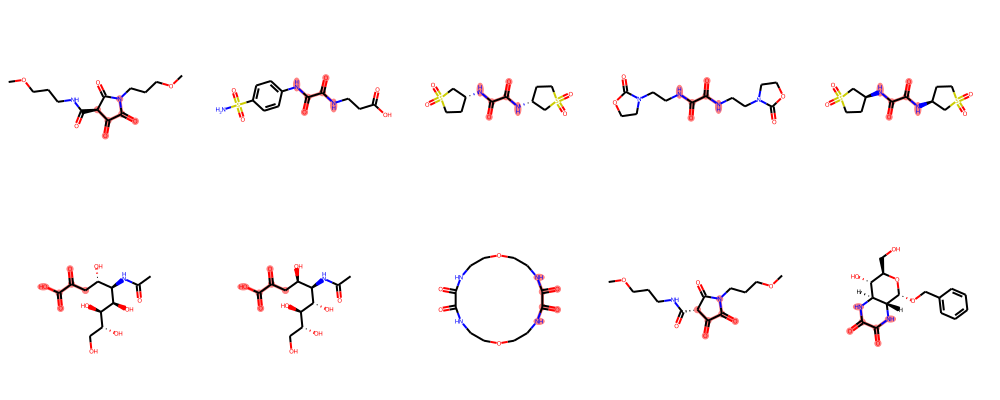

In [142]:
from rdkit import Chem
from rdkit.Chem import Draw

mol_list = [Chem.MolFromSmiles(x) for x in smiles_list]
dicarbonyl = Chem.MolFromSmarts('*C(=O)C(=O)*')
match_list = [mol.GetSubstructMatch(dicarbonyl) for mol in mol_list]
Draw.MolsToGridImage(mol_list,highlightAtomLists=match_list,molsPerRow=5)

As we can see above, the molecules do indeed have dicarbonyl groups. If we wanted to we could similarly evaluate other filters.

**Using the predictive model**


The GraphConv model we created can now be applied used to search the set of commercially available compounds we just filtered.
Applying the model will consist of a few steps.

Load the model from disc
Create a featurizer
Read an featurize the molecules that we will run through the model
Examine the scores for the predictions
Examine the chemical strucutres of the top predicted molecules
Cluster the selected molecules
Write the selected molecules from each cluster to a csv file
We will begin by importing the necessary libraries

In [143]:
import deepchem as dc
import pandas as pd
from rdkit.Chem import PandasTools, Draw
from rdkit import DataStructs
from rdkit.ML.Cluster import Butina
from rdkit.Chem import rdMolDescriptors as rdmd
import seaborn as sns

We then read the model that we generated earlier from disc

In [ ]:
model = dc.models.GraphConvModel(1, batch_size=128, mode='classification',model_dir="model_dir")
model.restore()

In order to generated predictions from our model, we first need to featurize the molecules we plan to use to generate predictions.

In [146]:
featurizer = dc.feat.ConvMolFeaturizer()

In order to featurize the molecules, we need to transform our SMILES file into a csv. The DeepChem featurizer also requires an activity column, so we will add one then write the file to csv. Is there another way to do this?

In [148]:
df = pd.read_csv("zinc.smi",sep=" ",header=None)
df.columns=["SMILES","Name"]
rows,cols = df.shape
df["Val"] = [0] * rows

In [149]:
df.head()

,SMILES,Name,Val
0,CN1C(=O)C[C@H](N2CCN(C(=O)CN3CCCC3)CC2)C1=O,ZINC000000036436,0
1,CC(=O)NC[C@H](O)[C@H]1O[C@H]2OC(C)(C)O[C@H]2[C...,ZINC000000041101,0
2,C1CN(c2nc(-c3nn[nH]n3)nc(N3CCOCC3)n2)CCO1,ZINC000000054542,0
3,OCCN(CCO)c1nc(Cl)nc(N(CCO)CCO)n1,ZINC000000109481,0
4,COC(=O)c1ccc(S(=O)(=O)N(CCO)CCO)n1C,ZINC000000119782,0


In [150]:
infile_name = "zinc_filtered.csv"
df.to_csv(infile_name,index=False)

We can the read this csv file with a loader and featurize the molecules we plan to predict.

In [151]:
loader = dc.data.CSVLoader(tasks=['Val'], smiles_field="SMILES", featurizer=featurizer)
dataset = loader.featurize(infile_name, shard_size=8192)

smiles_field is deprecated and will be removed in a future version of DeepChem.Use feature_field instead.
/usr/local/lib/python3.7/site-packages/deepchem/data/data_loader.py:162: FutureWarning: featurize() is deprecated and has been renamed to create_dataset().featurize() will be removed in DeepChem 3.0
  "featurize() will be removed in DeepChem 3.0", FutureWarning)


The featurized molecules can be used to generate predcitions with the model

In [152]:
pred = model.predict(dataset)
pred_df = pd.DataFrame([x.flatten() for x in pred],columns=["Neg","Pos"])

A distribtion plot provides a nice overview of the distribution of scores. We can see that only a few molecules have scores >= 0.3.
We can use this value as a preliminary cutoff for molecules that we may
want to screen experimentally.

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


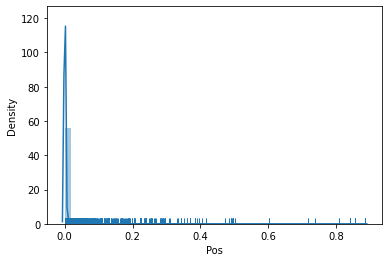

In [153]:
sns.distplot(pred_df.Pos,rug=True)

The dataframe with the scores can be joined to the dataframe with the SMILES. This will give us the ability to view the top scoring molecules.

In [154]:
combo_df = df.join(pred_df,how="outer")

combo_df.sort_values("Pos",inplace=True,ascending=False)

Adding a molecule column to the dataframe enables us to look at the chemical strucutres of the hits.

,SMILES,Name,Val,Neg,Pos,Mol
1127,CNC(=O)c1cn([C@@H]2O[C@@H](CO)[C@@H](O)[C@@H]2...,ZINC000004824758,0,0.116854,0.883146,
1126,CNC(=O)c1cn([C@H]2O[C@@H](CO)[C@@H](O)[C@@H]2O...,ZINC000004824757,0,0.116854,0.883146,
1125,CNC(=O)c1cn([C@@H]2O[C@@H](CO)[C@@H](O)[C@H]2O...,ZINC000004824756,0,0.116854,0.883146,
1124,CNC(=O)c1cn([C@H]2O[C@@H](CO)[C@@H](O)[C@H]2O)...,ZINC000004824755,0,0.116854,0.883146,
1023,OCCNc1ncnc2c1ncn2[C@H]1O[C@@H](CO)[C@@H](O)[C@...,ZINC000001685071,0,0.144789,0.855211,

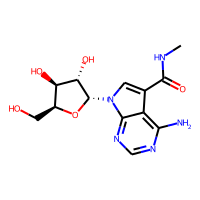
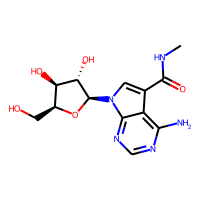
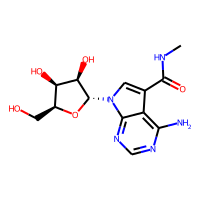
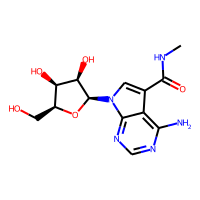
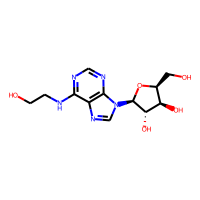

In [155]:
PandasTools.AddMoleculeColumnToFrame(combo_df,"SMILES","Mol")
combo_df.head()

Based on what we see above, it looks like many of the hits are similar. Let's look at a few more molecules.

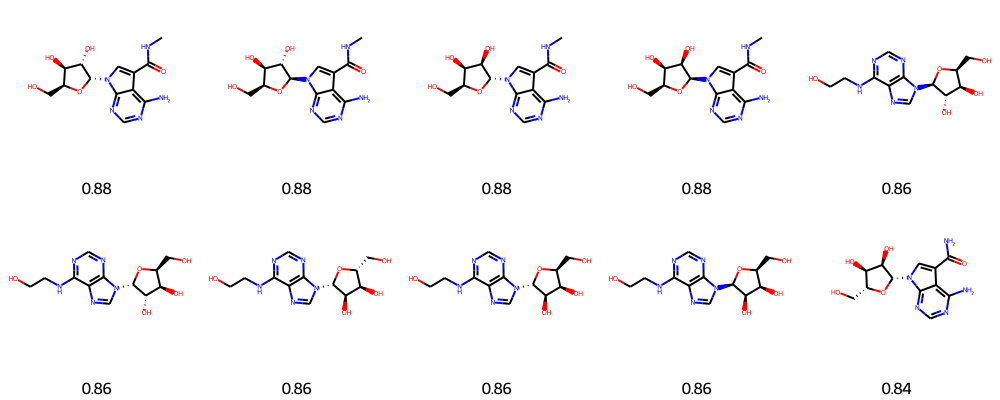

In [156]:
Draw.MolsToGridImage(combo_df.Mol[:10],molsPerRow=5,legends=["%.2f" % x for x in combo_df.Pos[:10]])


Indeed many of the molecules are very similar and might end up being redundant in our screen. One way of being more efficient with our screen would be to cluster the molecules and only screen the highest scoring molecule in each cluster. The RDKit has an implementation of the Butina clustering method, one of the most highly used methods in Cheminformatics. A small amount of code is necessary to cluster a set of molecules. The only parameter required for Butina clustering is the cluster cutoff. If the Tanimoto similarity of two molecules is greater than the cutoff, the molecules are put into the same cluster. If the similarity is less than the cutoff the molecules are put into different clusters.

In [157]:
def butina_cluster(mol_list,cutoff=0.35):
    fp_list = [rdmd.GetMorganFingerprintAsBitVect(m, 3, nBits=2048) for m in mol_list]
    dists = []
    nfps = len(fp_list)
    for i in range(1,nfps):
        sims = DataStructs.BulkTanimotoSimilarity(fp_list[i],fp_list[:i])
        dists.extend([1-x for x in sims])
    mol_clusters = Butina.ClusterData(dists,nfps,cutoff,isDistData=True)
    cluster_id_list = [0]*nfps
    for idx,cluster in enumerate(mol_clusters,1):
        for member in cluster:
            cluster_id_list[member] = idx
    return cluster_id_list


Before clustering, we will create a new dataframe with only the top 100 scoring molecules. Since combo_df is already sorted, we only have to use the "head" function to select the first 100 rows in the dataframe.

In [158]:
best_100_df = combo_df.head(100).copy()


We can then create a new column containing the cluster identifier for each compound.

,SMILES,Name,Val,Neg,Pos,Mol,Cluster
1127,CNC(=O)c1cn([C@@H]2O[C@@H](CO)[C@@H](O)[C@@H]2...,ZINC000004824758,0,0.116854,0.883146,,2
1126,CNC(=O)c1cn([C@H]2O[C@@H](CO)[C@@H](O)[C@@H]2O...,ZINC000004824757,0,0.116854,0.883146,,2
1125,CNC(=O)c1cn([C@@H]2O[C@@H](CO)[C@@H](O)[C@H]2O...,ZINC000004824756,0,0.116854,0.883146,,2
1124,CNC(=O)c1cn([C@H]2O[C@@H](CO)[C@@H](O)[C@H]2O)...,ZINC000004824755,0,0.116854,0.883146,,2
1023,OCCNc1ncnc2c1ncn2[C@H]1O[C@@H](CO)[C@@H](O)[C@...,ZINC000001685071,0,0.144789,0.855211,,5

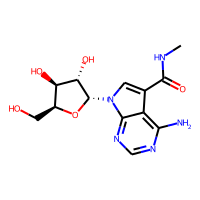
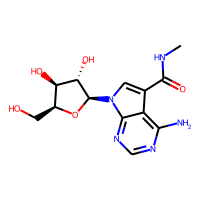
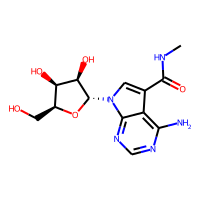
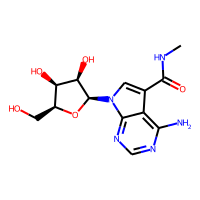
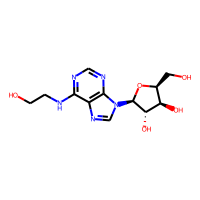

In [159]:
best_100_df["Cluster"] = butina_cluster(best_100_df.Mol)

best_100_df.head()

We can use the "unique" function to determine how many unique clusters we have.

In [160]:
len(best_100_df.Cluster.unique())

44